In [2]:
import os
import platform
import time
import math
import warnings
import torch
import torch.distributed as dist
from torch import optim
from torch.nn.parallel import DistributedDataParallel
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader, DistributedSampler
from contextlib import nullcontext
from model.model import Transformer
from model.LMConfig import LMConfig
from model.dataset import PretrainDataset

# 忽略警告信息
warnings.filterwarnings('ignore')

# 定义日志打印函数，仅在主进程（rank 0）打印日志信息
def Logger(content):
    if not ddp or dist.get_rank() == 0:
        print(content)

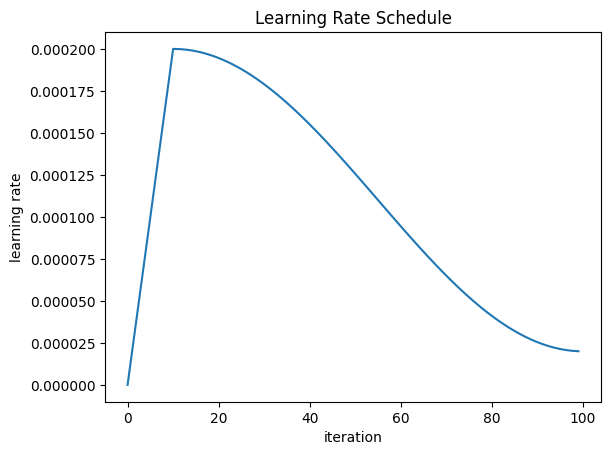

In [7]:
learning_rate = 2e-4
def get_lr(it, all):
    warmup_iters = 10  # 预热迭代次数
    lr_decay_iters = all  # 学习率衰减的总迭代次数
    min_lr = learning_rate / 10  # 最小学习率

    # 如果当前迭代次数小于预热迭代次数，使用线性预热策略
    if it < warmup_iters:
        return learning_rate * it / warmup_iters
    # 如果当前迭代次数大于衰减迭代次数，返回最小学习率
    if it > lr_decay_iters:
        return min_lr
    # 计算衰减系数，使用余弦退火策略
    decay_ratio = (it - warmup_iters) / (lr_decay_iters - warmup_iters)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio))
    return min_lr + coeff * (learning_rate - min_lr)
# 根据get_lr画出学习率曲线
import matplotlib.pyplot as plt
iters = [i for i in range(100)]
lrs = [get_lr(i, 100) for i in iters]
plt.plot(iters, lrs)
plt.xlabel('iteration')
plt.ylabel('learning rate')
plt.title('Learning Rate Schedule')
plt.show()
